# A. Cofee Time
Каждое утро пользователи Карт выбирают подходящую для них кофейню по множеству критериев. Давайте рассмотрим только два фактора, влияющие на их выбор: расстояние до пользователя и рейтинг кофейни. Имеется несколько тысяч попарных оценок кофеен от реальных пользователей, в каждой из которых одна пара (расстояние, рейтинг) сравнивается с другой. Необходимо построить модель, монотонно зависящую от двух этих факторов, которая согласуется с наибольшей долей оценок.

*`restaurants_train.txt` был переписан в эквивалентный `restaurants_train.csv`*

<h2>Обучающий датасет restaurants_train.txt</h2>

Каждая его строка содержит 5 чисел, разделённых табуляцией: winner, r1​, r2​, d1​, d2​. При этом winner равен 0, если победила первая кофейня, 1, если второй и 0.5, если случилась ничья. Пары $d_i r_i​$ соответствуют рейтингам и расстояниям для первой и второй кофейни. Рейтинги $r_i$ равны либо −1, что означает, что рейтинг отсутствует, либо принимают действительные значения от 0 до 10.

In [46]:
import numpy as np
import pandas as pd

In [47]:
restourants = pd.read_csv("../data/restaurants_train.csv")

In [48]:
restourants.head()

,winner,rating_1,rating_2,dist_1,dist_2
0,0.5,8.154642,-1.000000,0.000552,0.000483
1,1.0,-1.000000,9.105132,0.075709,0.024765
2,0.0,7.349630,-1.000000,0.045557,0.006901
3,0.0,7.077312,-1.000000,0.000369,0.004083
4,1.0,-1.000000,-1.000000,0.002481,0.002171


In [49]:
# По условию отсутсвие рейтинга - -1 в данных
print((restourants == -1).sum())

print(f"Количество пропусков в rating_1: {(restourants.rating_1 == -1).sum() / len(restourants.rating_2):.2f}%")
print(f"Количество пропусков в rating_2: {(restourants.rating_2 == -1).sum() / len(restourants.rating_2):.2f}%")

winner        0
rating_1    408
rating_2    438
dist_1        0
dist_2        0
dtype: int64
Количество пропусков в rating_1: 0.41%
Количество пропусков в rating_2: 0.44%


In [50]:
restourants[restourants == -1] = pd.NA
restourants.head()

,winner,rating_1,rating_2,dist_1,dist_2
0,0.5,8.154642,NaN,0.000552,0.000483
1,1.0,NaN,9.105132,0.075709,0.024765
2,0.0,7.349630,NaN,0.045557,0.006901
3,0.0,7.077312,NaN,0.000369,0.004083
4,1.0,NaN,NaN,0.002481,0.002171


# EDA

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

## Заполнение пропусков (прототип)

In [ ]:
# Отноистельно его найдем группы средних
rest_no_na = restourants.dropna().copy()

# Посчитаем разницы
rest_no_na["rate_diff"] = rest_no_na.rating_1 - rest_no_na.rating_2
rest_no_na["dist_diff"] = rest_no_na.dist_1 - rest_no_na.dist_2

# Составим таблицу средних
winner_avg_table = rest_no_na.groupby("winner").agg({
    "rate_diff":"mean",
    "dist_diff":""
}).rename(columns={"rate_diff":"avg_rate_diff", "dist_diff":"avg_dist_diff"})

winner_avg_table

,avg_rate_diff,avg_dist_diff
winner,,
0.0,0.559663,0.000213
0.5,0.031243,0.031944
1.0,-0.588126,-0.008256


Text(0.5, 1.0, '95% интервалы разницы расстояний')

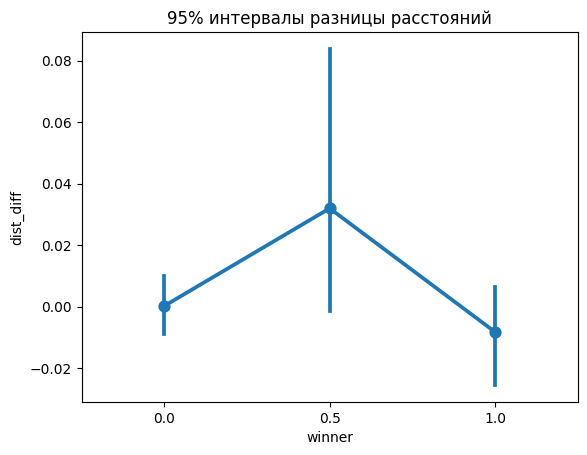

In [63]:
sns.pointplot(rest_no_na,x="winner",y="dist_diff")
plt.title("95% интервалы разницы расстояний")

Из графика видно, что границы пересекаются, значит отрезаем по среднему `winner_0.5` для определения принадлежания к группе `winner_0` или `winner_1`

In [64]:
def fillNA(row):
    """
    Fill rating NA values by group means

    Input:
        `row` - row to fill
    
    Output:
        rating NA filled dataframe
    """

    # Из таблицы `winner_avg_table`
    winner_0 = 0.559663
    winner_5 = 0.031243	
    winner_1 = -0.588126


    if (row.dist_1 - row.dist_2 <= winner_5): #Для winner 0-1
        if(row.dist_1 - row.dist_2 >= winner_0): #Для winner 0
            if(row.rating_1.isna()):
                row.rating_1 += winner_0
            else:
                row.rating_2 -= winner_0  
        else: # Для winner 1
            if(row.rating_1.isna()):
                row.rating_1 += winner_1
            else:
                row.rating_2 -= winner_1 

    else: # Для winner 0.5
        if(row.rating_1.isna()):
            row.rating_1 += winner_5
        else:
            row.rating_2 -= winner_5       